#  Spike PAtterns DEtection using SPADE


In [1]:
import numpy as np
import quantities as pq
import neo
import elephant
import viziphant
np.random.seed(4542)

## introducing heterogeneous delays

the function developed in the scan + a shift in time

In [2]:
t_stop = 10*pq.s
slope = 1.
A_sync = 0.05
shift = 0.0
A = [0]+[1.-A_sync]+[0]*8+[A_sync]
spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=10*pq.s)
                             


Add a shift:

In [3]:
spiketrains[0].times + 4.2*pq.s

array([ 4.21033654,  4.3236458 ,  4.78563655,  4.81982206,  5.70288547,
        5.78349493,  6.50615325,  6.52446731,  6.66094562,  7.11064866,
        7.22049755,  7.55124464,  8.27516523,  8.35311184,  8.9816976 ,
        8.99946049,  9.03841423,  9.34689651,  9.43959197,  9.80280617,
        9.90047019,  9.94452528, 10.22852998, 10.61353115, 10.74317218,
       11.38356847, 11.68884206, 11.85744823, 12.36421624, 13.21747938,
       13.33542415, 13.76103434, 13.88449406, 13.97526831, 13.98870717]) * s

Wrap around time:

In [4]:
np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 10*pq.s))

array([0.22852998, 0.61353115, 0.74317218, 1.38356847, 1.68884206,
       1.85744823, 2.36421624, 3.21747938, 3.33542415, 3.76103434,
       3.88449406, 3.97526831, 3.98870717, 4.21033654, 4.3236458 ,
       4.78563655, 4.81982206, 5.70288547, 5.78349493, 6.50615325,
       6.52446731, 6.66094562, 7.11064866, 7.22049755, 7.55124464,
       8.27516523, 8.35311184, 8.9816976 , 8.99946049, 9.03841423,
       9.34689651, 9.43959197, 9.80280617, 9.90047019, 9.94452528]) * s

Sort in time:

In [5]:
np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 10*pq.s))

array([0.22852998, 0.61353115, 0.74317218, 1.38356847, 1.68884206,
       1.85744823, 2.36421624, 3.21747938, 3.33542415, 3.76103434,
       3.88449406, 3.97526831, 3.98870717, 4.21033654, 4.3236458 ,
       4.78563655, 4.81982206, 5.70288547, 5.78349493, 6.50615325,
       6.52446731, 6.66094562, 7.11064866, 7.22049755, 7.55124464,
       8.27516523, 8.35311184, 8.9816976 , 8.99946049, 9.03841423,
       9.34689651, 9.43959197, 9.80280617, 9.90047019, 9.94452528]) * s

https://neo.readthedocs.io/en/stable/core.html?highlight=spiketrain#example-spiketrain

In [6]:
neo.SpikeTrain(np.sort(np.mod(spiketrains[0].times + 4.2*pq.s, 10*pq.s)), t_start=0*pq.s, t_stop=10*pq.s)



SpikeTrain

In [7]:
for i_st in range(10):
    delay = (i_st*slope)*pq.ms
    spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
    spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.s, t_stop=t_stop)

In [8]:
print(slope, 'max delay=', 10*slope, 'ms')

1.0 max delay= 10.0 ms


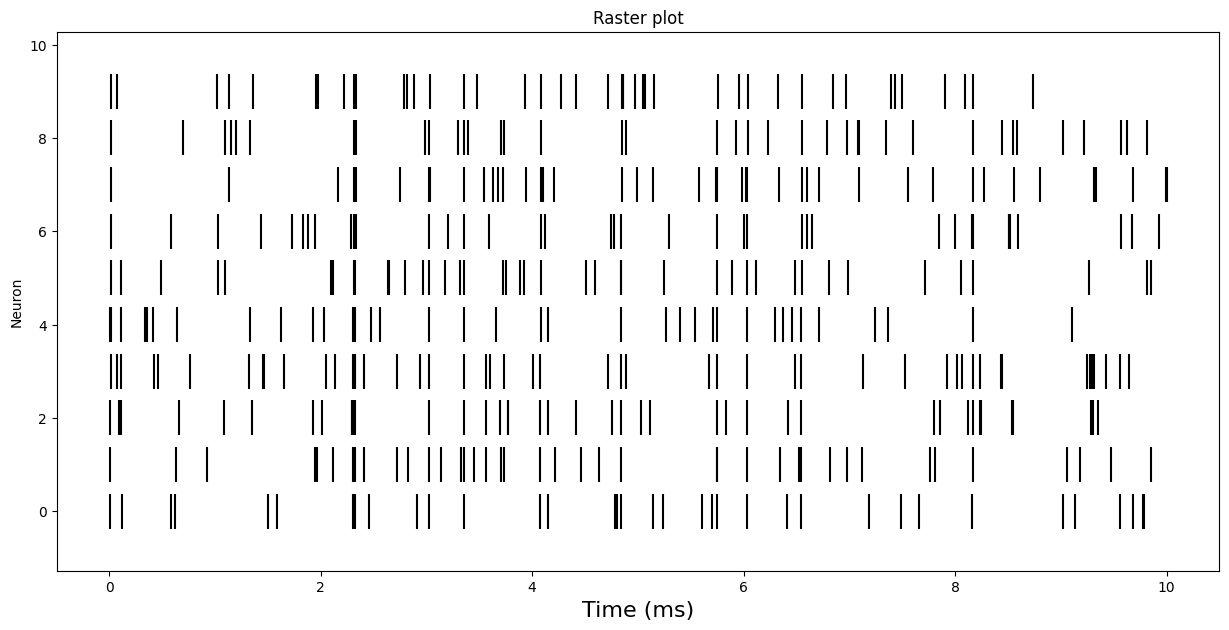

In [9]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.eventplot([spiketrains[i].magnitude for i in range(len(spiketrains))], linelengths=0.75, color='black')
plt.xlabel('Time (ms)', fontsize=16)
plt.ylabel('Neuron')
plt.title("Raster plot");

All in one function:

In [10]:

def generate_and_test(A_sync=A_sync, shift=shift, winlen=1, slope=slope, t_stop=t_stop):

    A = [0]+[1.-A_sync]+[0]*8+[A_sync]
    spiketrains = elephant.spike_train_generation.compound_poisson_process(
                             rate=5*pq.Hz, A=A, shift=shift*pq.ms, t_stop=t_stop)
    for i_st in range(10):
        delay = (i_st*slope)*pq.ms
        spike_times = np.sort(np.mod(spiketrains[i_st].times + delay, t_stop))
        spiketrains[i_st] = neo.SpikeTrain(spike_times, t_start=0*pq.s, t_stop=t_stop)

    for i in range(90):
        spiketrains.append(elephant.spike_train_generation.homogeneous_poisson_process(
            rate=5*pq.Hz, t_stop=10*pq.s))
    patterns = elephant.spade.spade(
                                spiketrains=spiketrains, binsize=1*pq.ms, winlen=winlen, min_spikes=3,
                                n_surr=100, dither=5*pq.ms,
                                psr_param=[0,0,0],
                                output_format='patterns')['patterns']
    return patterns


* changing the synchrony probability to check when SPADE will begin to fail:


In [11]:
for slope_ in np.logspace(-1, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_)
    print(slope_, 'max delay=', 10*slope, 'ms: ', patterns)

/usr/local/lib/python3.10/site-packages/elephant/spade.py:679: UserWarning: Optimized C implementation of FCA (fim.so/fim.pyd) not found in elephant/spade_src folder, or not compatible with this Python version. You are using the pure Python implementation of fast fca.
  warnings.warn(


Time for data mining: 48.54175591468811


In [ ]:
for slope_ in np.logspace(-1, 1, 10, base=10):
    patterns = generate_and_test(slope=slope_, winlen=10)
    print(slope_, 'max delay=', 10*slope, 'ms: ', patterns)